In [1]:
import pandas as pd
import numpy as np
import json
import pickle
import matplotlib.pyplot as plt
import logging
import scipy.stats as sts
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import os

from arch import arch_model

In [2]:
ini_work_dir = os.getcwd()
os.chdir('..')

In [3]:
from rules_related import combine_rules_outputs
from whole_algorithm import train_model
from auxiliary import calc_log_returns, unpack_1d_parameters
from multivariate_normal_distribution import LongMultivariateNormal
from model import FuzzyVolatilityModel
from antecedent_fitting import fit_antecedent_params
from local_models import calculate_retraining_garch_forecasts

In [4]:
with open('config.json') as file:
    config = json.load(file)

In [5]:
files_folder = config['files_folders']['processed']
RESEARCH_RESULTS_FOLDER = config['files_folders']['research_results']
antecedent_params_folder = config['files_folders']['antecedent_params_sets']
logs_folder = config['files_folders']['logs']

In [6]:
TESTED_MODEL_FILE_NAME = 'tested_model_wo_seas'

In [7]:
logger = logging.getLogger(f'test_calc_wo_seas')  # apf == antecedent params fitting

_log_file = f'{logs_folder}/{logger.name}.log'
logging.basicConfig(level=logging.INFO,
                    filename=_log_file,
                    filemode='w',
                    format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                    datefmt='%H:%M:%S')

In [8]:
pd.options.display.precision = 15
pd.options.display.max_colwidth = 300

# Reading

In [9]:
_files = ['fitting_consequent_params_wo_seas_result_nb_0_2022-09-30 09-05-59.250974.pkl']
res_big = [pd.read_pickle(f'{RESEARCH_RESULTS_FOLDER}/{_file}') for _file in _files]
_res = [_elem for res_piece in res_big for _elem in res_piece['result']].copy()

res = pd.DataFrame.from_records(_res).copy()

In [10]:
if (res['status'] != 0).any():
    raise Error('Not all models were fitted')

In [11]:
fitted_ap = res[res['rmse'] == res['rmse'].min()].iloc[0]['antecedent_params'].copy()
fitted_ap

[{'centers': (-0.095, 0.005000000000000001, -0.005000000000000001, 0.04),
  'variances': (0.06, 0.06, 0.04, 0.06),
  'n_clusters': 4}]

In [12]:
fvm = res[res['rmse'] == res['rmse'].min()].iloc[0]['fvm']

In [13]:
test = res_big[0]['test'].copy()
data_to_cluster_test = res_big[0]['data_to_cluster_test'].copy()

In [15]:
# with open('antecedent_params_sets/current_antecedent_fitting_metadata_wo_seas.pkl', 'rb') as _file:
#     cafmd = pickle.load(_file)

In [17]:
# test = cafmd['test'].copy()
# data_to_cluster_test = cafmd['data_to_cluster_test'].copy()

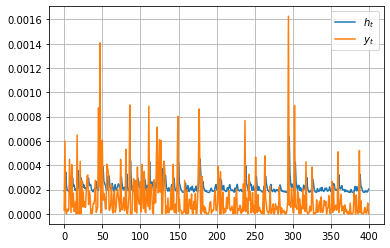

In [18]:
_slc = slice(-400, None)
plt.plot(fvm.h[:-1][_slc], label='$h_t$')
plt.plot(res_big[0]['train'].values[_slc] ** 2, label='$y_t$')

plt.legend()
plt.grid()

In [19]:
res.sort_values('rmse', ascending=True)

,antecedent_params,status,fvm,mse,rmse,mape,exception,traceback
1117,"[{'centers': (-0.095, 0.005000000000000001, -0.005000000000000001, 0.04), 'variances': (0.06, 0.06, 0.04, 0.06), 'n_clusters': 4}]",0,<model.FuzzyVolatilityModel object at 0x2add93dfd2b0>,0.000000760514742,0.000872074963722,1.122053535406174,None,None
1108,"[{'centers': (-0.095, 0.005000000000000001, -0.005000000000000001, 0.04), 'variances': (0.04, 0.06, 0.04, 0.04), 'n_clusters': 4}]",0,<model.FuzzyVolatilityModel object at 0x2add93d9a070>,0.000000760514742,0.000872074963722,1.122053535543121,None,None
1165,"[{'centers': (-0.095, -0.035, 0.015, 0.04), 'variances': (0.06, 0.06, 0.04, 0.06), 'n_clusters': 4}]",0,<model.FuzzyVolatilityModel object at 0x2add9400c610>,0.000000760514742,0.000872074963722,1.122053535432431,None,None
989,"[{'centers': (-0.095, -0.015, -0.005000000000000001, 0.06), 'variances': (0.06, 0.06, 0.04, 0.06), 'n_clusters': 4}]",0,<model.FuzzyVolatilityModel object at 0x2add93875eb0>,0.000000760514742,0.000872074963722,1.122053535340660,None,None
407,"[{'centers': (-0.075, -0.035, -0.005000000000000001, 0.06), 'variances': (0.04, 0.06, 0.06, 0.06), 'n_clusters': 4}]",0,<model.FuzzyVolatilityModel object at 0x2add91f68880>,0.000000760514742,0.000872074963722,1.122053535560829,None,None
...,...,...,...,...,...,...,...,...
463,"[{'centers': (-0.05499999999999999, -0.015, 0.015, 0.06), 'variances': (0.06, 0.06, 0.06, 0.06), 'n_clusters': 4}]",0,<model.FuzzyVolatilityModel object at 0x2add921d2730>,0.000000760514747,0.000872074966459,1.122045929591097,None,None
527,"[{'centers': (-0.05499999999999999, -0.015, 0.035, 0.02), 'variances': (0.06, 0.06, 0.06, 0.06), 'n_clusters': 4}]",0,<model.FuzzyVolatilityModel object at 0x2add92497130>,0.000000760514747,0.000872074966459,1.122045929467222,None,None
512,"[{'centers': (-0.05499999999999999, -0.015, 0.035, 0.02), 'variances': (0.04, 0.04, 0.04, 0.04), 'n_clusters': 4}]",0,<model.FuzzyVolatilityModel object at 0x2add923ef1f0>,0.000000760514747,0.000872074966459,1.122045929435317,None,None
271,"[{'centers': (-0.075, 0.005000000000000001, -0.005000000000000001, 0.06), 'variances': (0.06, 0.06, 0.06, 0.06), 'n_clusters': 4}]",0,<model.FuzzyVolatilityModel object at 0x2add9198d970>,0.000000760514747,0.000872074966459,1.122045929571678,None,None


In [20]:
test

<DATE>
2020-01-03    0.009803811137246
2020-01-06    0.002662386290432
2020-01-08    0.013131121111568
2020-01-09    0.007935305929078
2020-01-10    0.008052449439401
                    ...        
2021-12-23   -0.008815656816666
2021-12-24   -0.002345509615600
2021-12-27    0.011772741444152
2021-12-28    0.005499817885985
2021-12-29   -0.013750064360213
Name: log return, Length: 504, dtype: float64

# CHANGING `n_points_fitting`

In [23]:
fvm.n_points_fitting = 504
fvm._fitting_slice = slice(-fvm.n_points_fitting if fvm.n_points_fitting is not None else None, None)

# Live feeding

In [ ]:
%%time

fvm.feed_daily_data(test, data_to_cluster=data_to_cluster_test)

In [ ]:
_cur_time = str(pd.Timestamp.today()).replace(':', '-')
print(_cur_time)

with open(f'{RESEARCH_RESULTS_FOLDER}/{TESTED_MODEL_FILE_NAME}_{_cur_time}.pkl', 'wb') as _file:
    pickle.dump(fvm, _file)

In [ ]:
fvm.hist_output

In [ ]:
fvm.membership_degrees_hist

In [ ]:
fvm._parameters_hist

In [ ]:
res_big[0].keys()

In [ ]:
mse = mean_squared_error(fvm.hist_output, test ** 2, squared=True)
rmse = mean_squared_error(fvm.hist_output, test ** 2, squared=False)

In [ ]:
rmse

In [ ]:
mse

In [ ]:
test.plot(grid=True)